In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import files 
%matplotlib inline

In [ ]:
spotify_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/spotify/data.csv')
genres_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/spotify/data_by_genres.csv')
data_by_year = pd.read_csv('/content/drive/My Drive/Colab Notebooks/spotify/data_by_year.csv')

In [ ]:
spotify_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [ ]:
spotify_data.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
114906,0.787,1970,0.105,['Stevie Wonder'],0.525,194360,0.526,0,05mkxgw4kGQnarKMEovShB,0.000604,10,0.1040,-10.625,1,Never Had A Dream Come True,31,1970-08-07,0.0306,103.490
100104,0.535,1977,0.340,['Steve Miller Band'],0.553,152427,0.297,0,65HKXd61Lp2HffCrPzz7cs,0.959000,8,0.0851,-16.414,1,Babes In The Wood,30,1977-01-01,0.0391,103.681
135581,0.317,1994,0.159,['Toad The Wet Sprocket'],0.424,272960,0.794,0,3Zyou0XYE5YH6QAYxqjjSJ,0.000059,4,0.0762,-7.890,1,Fly From Heaven,35,1994-04-27,0.0351,102.914
26437,0.713,1959,0.893,['Lloyd Price'],0.562,166507,0.504,0,5Gu2asdPkdaHUmnFZ1FX7I,0.000652,3,0.0987,-9.289,1,Just Because,29,1959-01-01,0.0272,114.033
43157,0.191,1949,0.768,['Sarah Vaughan'],0.294,189907,0.204,0,3Ryyop06mG54ktj2JJywKL,0.000000,3,0.2060,-11.266,1,"You're Mine, You",3,1949,0.0291,81.212


In [ ]:
# data cleaning
# remove square brackets and quotation marks in artist's name
spotify_data['artists'] = spotify_data['artists'].apply(lambda x: x[1:-1].replace("'", " "))
# corrective release date
spotify_data['release_date'] = pd.to_datetime(spotify_data['release_date'])

In [ ]:
spotify_data.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
97742,0.8470,1965,0.897000,Tom Lehrer,0.501,131893,0.451,0,2Bnbo39pUWykSMb0MGft4K,0.000000,3,0.7510,-12.767,1,The Folk Song Army,17,1965-01-01,0.8300,80.614
86792,0.9440,1993,0.364000,Banda Machos,0.804,188507,0.610,0,65lfzguWycfHortBjpZAwr,0.000023,10,0.0685,-5.022,1,Motivos,41,1993-10-06,0.0279,107.781
72515,0.5610,2007,0.000285,Paramore,0.467,209747,0.888,0,7tCnwq0Fy85y1tWktmXQ7u,0.000002,1,0.1460,-3.215,0,Miracle,47,2007-06-11,0.0681,163.014
89956,0.0369,2008,0.972000,"Dean Evenson , Scott Huckabay",0.107,470107,0.110,0,1Dk2yfU21TrinTb44Nr25J,0.961000,4,0.0790,-20.904,0,Third Eye Chakra - Light Vision,51,2008-06-10,0.0414,60.194
133349,0.8200,1982,0.234000,Survivor,0.473,231147,0.538,0,0Lx1G4MxI06OK8H3Fhw6rh,0.000001,2,0.2470,-13.962,1,Hesitation Dance,33,1982-01-01,0.0474,176.878


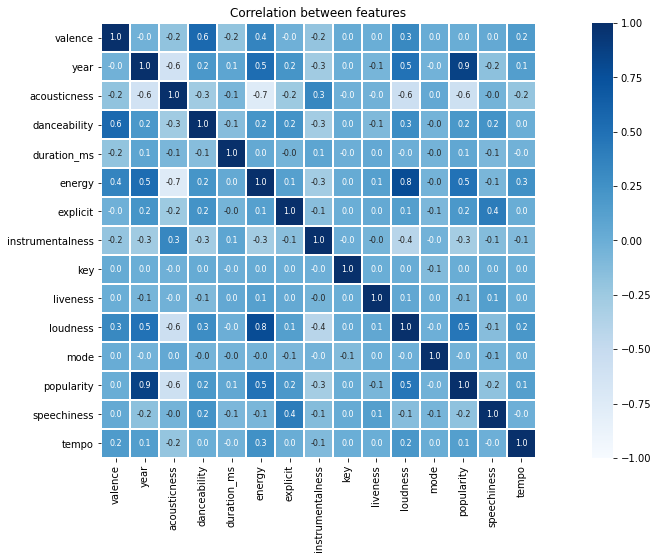

In [ ]:
# finding correlation between the featues
correlation = spotify_data.corr()

# correlation visualization using heatmap
plt.figure(figsize=(20,8))
sns.heatmap(correlation, vmax=1, vmin=-1, center=0,linewidth=.5,square=True, annot = True, annot_kws = {'size':8},fmt='.1f', cmap='Blues')
plt.title('Correlation between features')
plt.show()

<Figure size 1728x720 with 0 Axes>

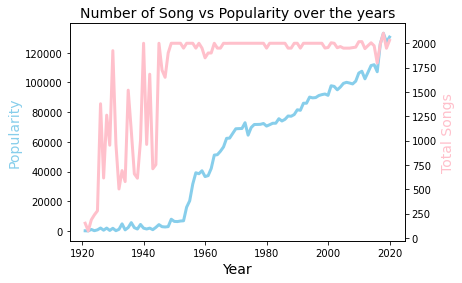

In [ ]:
# find number of song vs popularity
year_group = spotify_data.groupby(['year'], as_index = False)
tracks_popularity = year_group[['name', 'popularity']].sum()
tracks_count = year_group['name'].count()

plt.figure(figsize=(24,10))
fig, ax1 = plt.subplots()
# axis 1 is popularity
ax1.plot(tracks_popularity.year, tracks_popularity.popularity, color = 'skyblue', linewidth = 3)
ax1.set_title("Number of Song vs Popularity over the years", fontsize = 14)
ax1.set_xlabel("Year", fontsize = 14)
ax1.set_ylabel("Popularity", color = 'skyblue', fontsize = 14)

# second axis is total song in the year
ax2 = ax1.twinx()
ax2.plot(tracks_count.year, tracks_count.name, color = "pink", linewidth = 3)
ax2.set_ylabel("Total Songs", color = "pink", fontsize=14)

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe01664b3c8>,
      dtype=object)

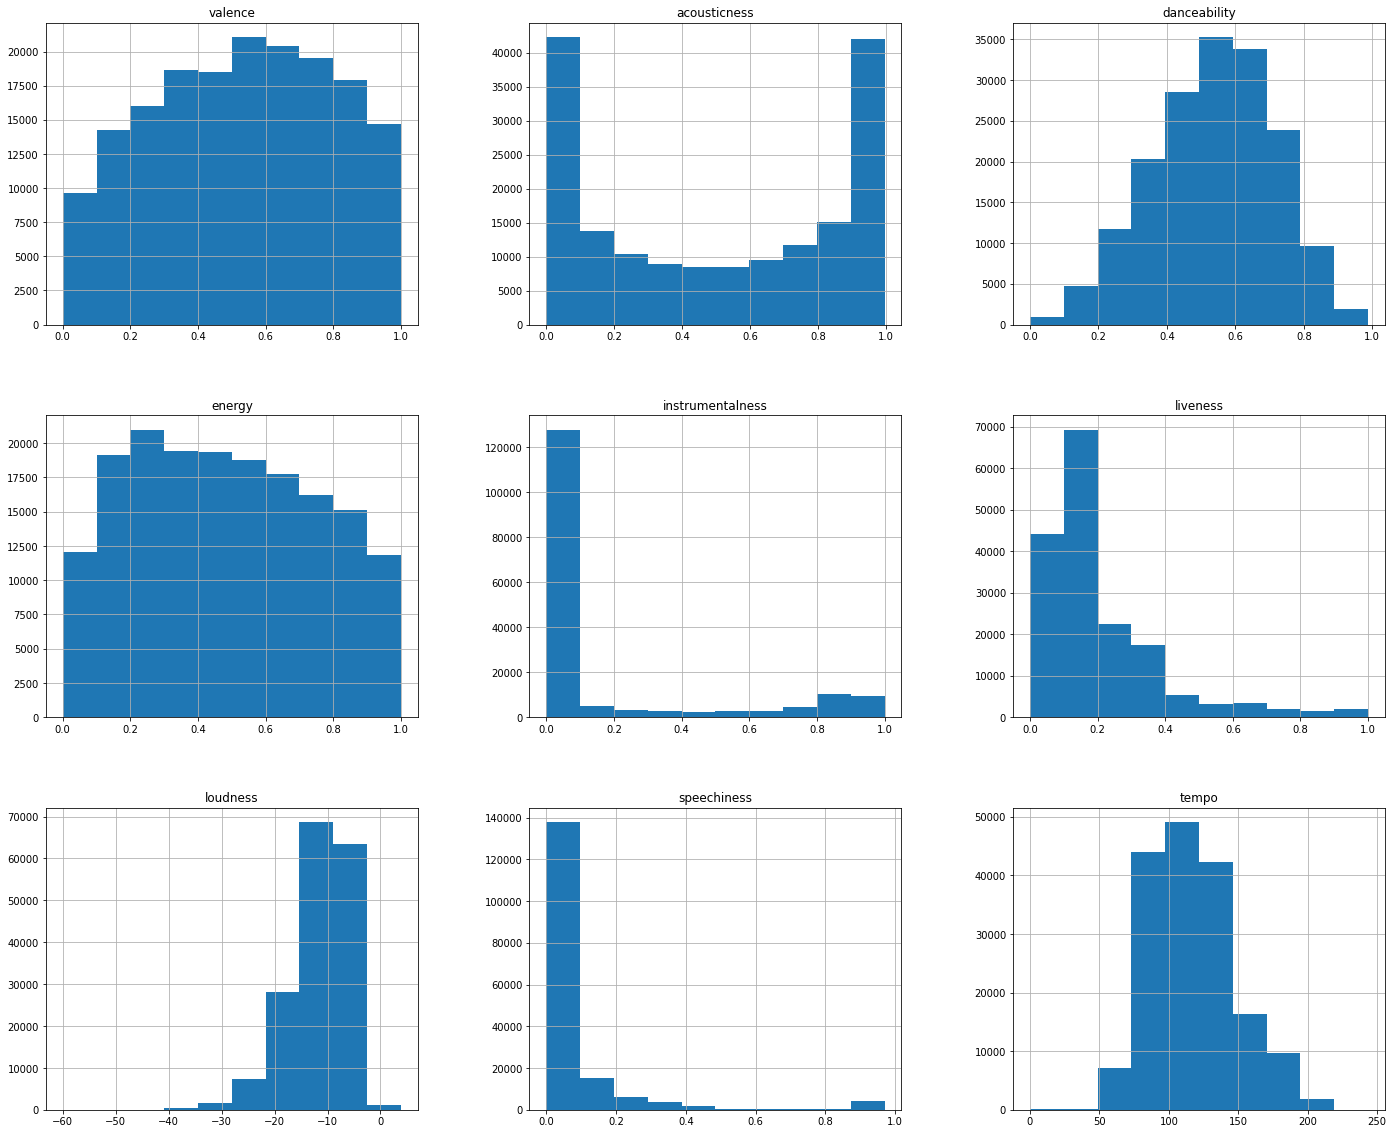

In [ ]:
# analysis the audio features
# non audio features
cols_to_drop = ['year', 'artists', 'duration_ms','explicit', 'id', 'key', 'name', 'release_date', 'mode', 'popularity']
# drop non audio features
audio_features = pd.DataFrame(spotify_data).drop(cols_to_drop, axis = 1)

# histogram
audio_features.hist(xlabelsize=10, figsize=(24,20))

In [ ]:
from sklearn import linear_model  # will be using for plotting trend line
from sklearn.preprocessing import MinMaxScaler # for normalizing data
from sklearn.cluster import KMeans # kmeans clustering

In [ ]:
# Data preprocessing

track_features = pd.DataFrame()
# normalization
normalization = MinMaxScaler()

for col in spotify_data.iloc[:, :-1].columns: 
  if spotify_data[col].dtypes in ['float64', 'int64']: # exclude year col 
    # normalize the float64 and int64 data type in the dataset
    normalization.fit(spotify_data[[col]])
    track_features[col] = normalization.transform(spotify_data[col].values.reshape(-1,1)).ravel()

In [ ]:
# Determine the best K value using elbow method to minimize SSE (Sum of Squared Error)

k_range = range(1,30) # k value within range 
sse = [] # SSE for each k value

for i in k_range:
  km = KMeans(n_clusters = i, random_state = 1)
  km.fit(track_features.sample(10000)) # take ten thousand samples to save computation power and time
  sse.append(km.inertia_)

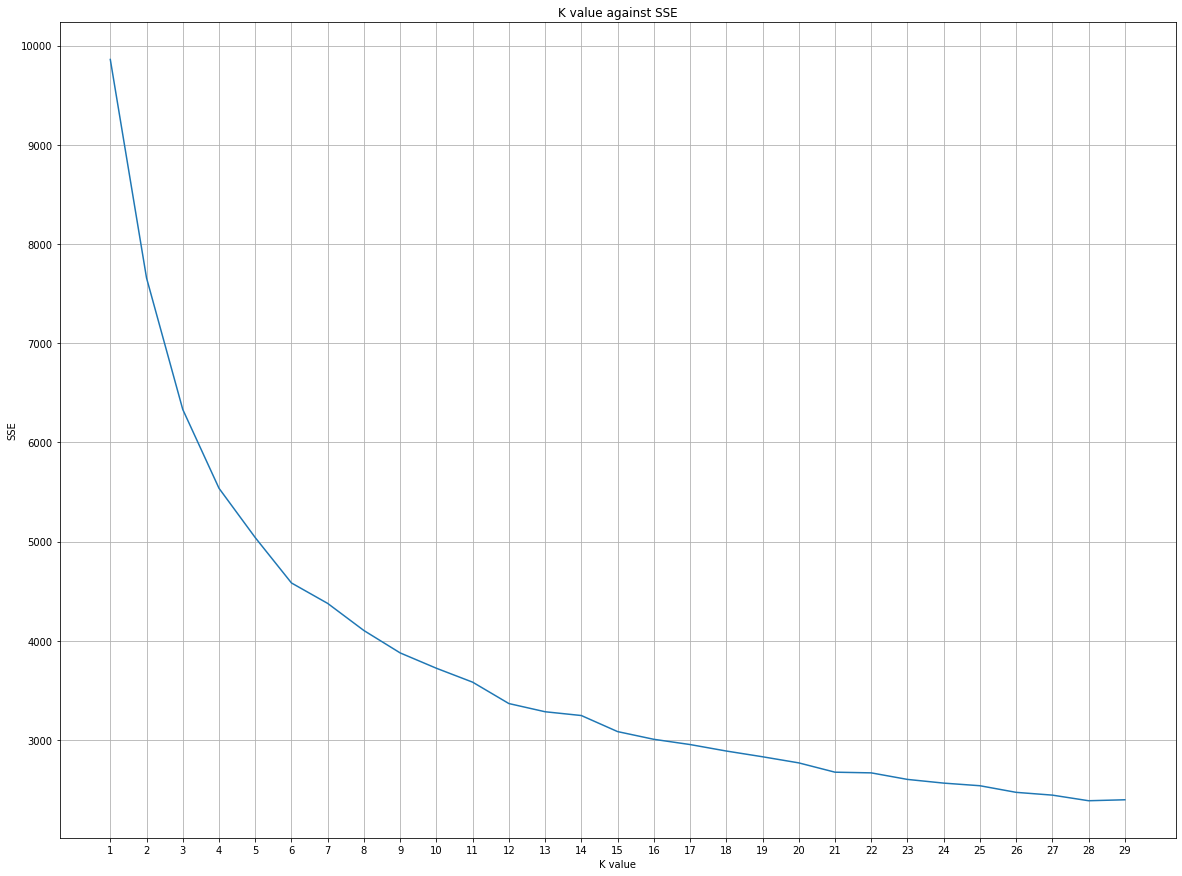

In [ ]:
# Plot K value vs SSE

plt.figure(figsize=(20,15))
plt.plot(k_range, sse)
plt.xlabel("K value")
plt.ylabel("SSE")
plt.title("K value against SSE")
plt.xticks(np.arange(min(k_range), max(k_range)+1, 1.0))
plt.grid()
plt.show()

In [ ]:
# Seems K value 20 is good 
km = KMeans(n_clusters=20)
predicted_genres = km.fit_predict(track_features)

track_features['predicted_genres'] = predicted_genres
track_features['predicted_genres'] = track_features['predicted_genres'].apply(lambda x: 'Cluster' + str(x))

track_features.sample(5)

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,predicted_genres
148098,0.537,0.616162,0.331325,0.661943,0.057733,0.693,0.0,0.000276,0.000000,0.1440,0.763699,1.0,0.30,0.059278,Cluster17
72155,0.416,0.848485,0.844378,0.407895,0.029737,0.280,0.0,0.000023,0.636364,0.1480,0.697800,0.0,0.52,0.065773,Cluster5
154030,0.210,0.919192,0.665663,0.543522,0.052902,0.440,0.0,0.051500,0.181818,0.6840,0.794707,1.0,0.00,0.024948,Cluster15
45268,0.824,0.393939,0.776104,0.565789,0.024723,0.405,0.0,0.000004,0.818182,0.0968,0.781098,1.0,0.22,0.031443,Cluster10
48726,0.554,0.565657,0.216867,0.486842,0.064041,0.763,0.0,0.000010,0.181818,0.2040,0.834735,1.0,0.52,0.027113,Cluster0


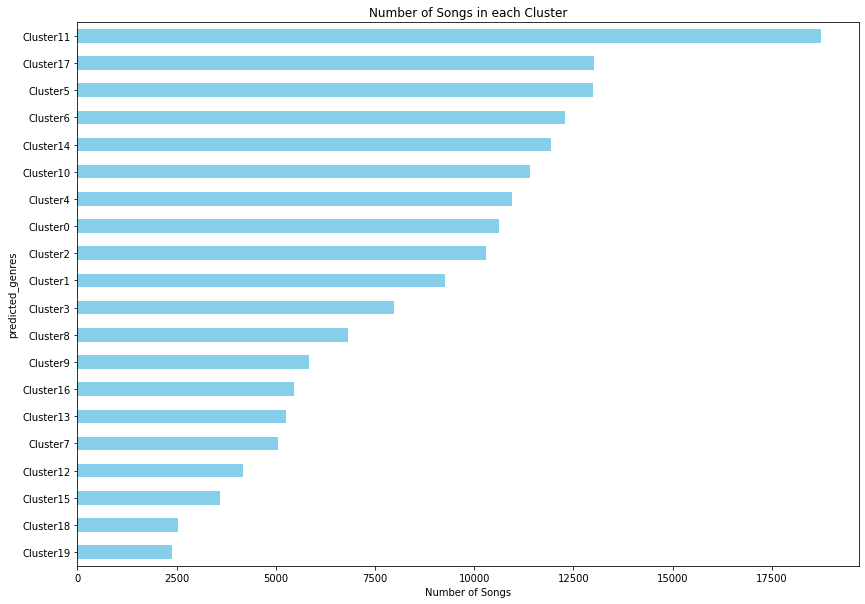

In [ ]:
# Number of songs in each cluster
genres_group = track_features.groupby(['predicted_genres']).size()
plt.figure(figsize=(14,10))
genres_group.sort_values(ascending=True).plot.barh(color='skyblue')
plt.xlabel('Number of Songs')
plt.title('Number of Songs in each Cluster')
plt.show()

In [ ]:
# read artists data
artists_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/spotify/data_by_artist.csv")
#artists_data = artists_data.rename(columns = {"count": "playCount"})

In [ ]:
# Replace all the features with the clusters
artists_data.iloc[:,1:-1] = normalization.fit_transform(artists_data.iloc[:,1:-1])
km = KMeans(n_clusters=20)
artists_data['genres'] = km.fit_predict(artists_data.iloc[:,1:-1])
artists_data = artists_data.iloc[:, [0,-3,-2,-1]]
artists_data.head()

,artists,mode,count,genres
0,"""Cats"" 1981 Original London Cast",1.0,10,17
1,"""Cats"" 1983 Broadway Cast",1.0,26,0
2,"""Fiddler On The Roof” Motion Picture Chorus",1.0,7,18
3,"""Fiddler On The Roof” Motion Picture Orchestra",1.0,27,18
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",1.0,7,17


In [ ]:
# Create a random user list as seed
artists_data['user_id'] = np.random.randint(1000,1400,len(artists_data))
artists_data['rating'] = np.random.randint(1,6,len(artists_data))
artists_data.sample(20)

,artists,mode,count,genres,user_id,rating
23561,Relyk,1.0,4,1,1071,1
8966,Erutan,0.0,2,3,1213,3
12356,Icona Pop,1.0,10,6,1119,4
3618,Bobby Van,0.0,3,3,1015,1
22229,Pest,0.0,2,16,1188,1
10597,Gerardo,0.0,2,7,1256,3
16347,Lee Dixon,1.0,4,12,1010,3
25723,Siegfried Vogel,1.0,1,14,1237,1
25754,Silke Avenhaus,1.0,2,18,1203,5
26388,Splinta,1.0,6,13,1313,5


In [ ]:
# Build Recommender

def recommender(user):
  # select user's most favourite genres
  fav_genre = artists_data[artists_data['user_id']==user].sort_values(by=['rating','count'], ascending=False)['genres'][:5]
  fav_genre = list(dict.fromkeys(fav_genre)) # remove duplicates 

  # remove artists in the lists that have been listened to before 
  listened_artist = artists_data.index[artists_data['artists'].isin(['Johann Sebastian Bach','Frédéric Chopin'])].tolist()

  # the artists not discovered by user yet
  remaining_artist = artists_data.drop(listened_artist, axis=0)
  CanBeRecommened =  remaining_artist[remaining_artist['genres'].isin(fav_genre)]

  # sort the popular artists in the user's favourite genre
  CanBeRecommened = CanBeRecommened.sort_values(by=['rating','count',], ascending=False)[['artists', 'genres', 'rating', 'count']][:5]

  # return artists name, genres, ratings, and played count
  return CanBeRecommened

In [ ]:
# Execute recommender for a user
recommender(1111)

,artists,genres,rating,count
8551,Ella Fitzgerald,18,5,951
3525,Bob Marley & The Wailers,6,5,536
30187,U2,6,5,420
28541,The Kinks,6,5,388
29019,The Shadows,13,5,304


In [ ]:
# check his favourite genres and the recommendation 
artists_data[artists_data.user_id==1111].sort_values(by='rating')['genres'].unique()

array([ 6, 18,  1,  0, 11,  5, 13, 17,  7,  4,  3, 16,  2, 19,  8, 15, 14,
       10, 12,  9], dtype=int32)

In [ ]:
# Cross validation for evaluating the cluster
from sklearn.model_selection import train_test_split

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/spotify/data.csv')

# maybe can use other K value to show clustering quality (SSE)
# or just use silhouette method to justify the k value 30
